# Dataset Explanation

## dataframes are made of...
- When called: Username(@shanalysis), Displayname(Shana Lee), Created_Date, Followers, Friends, Statuses, Favorites, Listeds, Medias, Tweeted_Date, Content, Replies, RTs, Likes, QRTs, Source, Hashtags
- Added during the analysis: Hashtags(list of hashtags), Create2Tweet(time duration took to tweet since account creation), Hashlen(# of hashtags used), Create2Tweetint(int form for caculation)

## Terminology
- Spams: spam tweets or accounts produced to attract users to illegal prostitution and porn sites. This does not include just naughty accounts used by normal users. Key and Line are mostly made of Spams
- Tweets with effort: Carefully made tweets made by people who are trying to be more formal and constructed to collect more followers or spread information. Creators are the most successful in making these tweets, verified by Twitter Korea. Note that Twitter is a social platform that people usually use to write down whatever they think simply under 120 characters, so people don't put that much effort compared to other social medias.
- df: dataframe
- spam df: Jejudf and Linedf

In [539]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from datetime import date
from datetime import timedelta
import sqlite3
import snscrape.modules.twitter as sntwitter

In [197]:
!{sys.executable} -m pip install KoNLPy

In [198]:
import konlpy #Special NLP package for Korean

# Import Files, Data Cleaning, and Function Preparation

In [112]:
types = ('Jeju','Line','Hash','Space','Key','Creator')

jejudf = pd.read_csv('Jeju_join.csv') 
hashdf = pd.read_csv('Hash_join.csv') 
linedf = pd.read_csv('Line_join.csv') 
spacedf = pd.read_csv('Space_join.csv') 
keydf = pd.read_csv('Key_join.csv') 
creatordf = pd.read_csv('Creator_join.csv') 

dfs = jejudf, linedf, hashdf, spacedf, keydf, creatordf
for item in dfs:
    item.drop(labels=['Unnamed: 0'], axis=1, inplace=True) #remove row index created from SQL
    item.Created_Date=pd.to_datetime(item.Created_Date) #make string to date so that we can calculate easier
    item.Tweeted_Date=pd.to_datetime(item.Tweeted_Date)
    item.Username=pd.DataFrame(item.Username).transpose().drop_duplicates().transpose()
    #drop duplicate column (Username) from joinning tables

## Basic Calculations and Numerization

In [505]:
for df in dfs:
    #ages of tweets
    df['Create2Tweet']=(df.Tweeted_Date-df.Created_Date)
    #Get hashtags back
    pattern=r"#(\w+)"
    new_hash=df.Content.map(lambda x: re.findall(pattern,x))
    df.Hashtags=new_hash
    df['Hashlen']=df.Hashtags.map(lambda x: len(x))
    df['Create2Tweetint']=(df.Create2Tweet.astype(int)/86399905315172.25).astype(int)


/var/folders/p8/ggm3r0bx14sbjsb1ksyg2y6c0000gn/T/ipykernel_25098/452137645.py:9: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df['Create2Tweetint']=(df.Create2Tweet.astype(int)/86399905315172.25).astype(int)


# Account Analysis

## Database Verificiation and Cleaning
Quick introduction of database characteristic and verification of those characteristics. Drop datas that don't follow the expectation

### Jeju (110 items)
- Search Results of 제주아이스크림('Jeju icecream'), which is a targed keyword to promote porn sites.
- Manually verified to only have keyword spamed tweets(except one in index 97), either in a form of keyword \n keyword \n... or a line of around three other targetted keywords
- NV ratio(Noun to Verb ratio) will be proved to be very low in the joint analysis below.
- Can verify more targeted keywords other than 제주아이스크림 based on the contents we got for later if we need more data.

In [657]:
jejudf[['Displayname','Content']].head(5)

,Displayname,Content
0,⬅ㅋr톡-ㄹr인: V772⬅ 출장만남출장업소출장샵조건만남출장마사지애인대행 파주시,⌚\n지글지글 사하구맛집 린헤어 제주아이스크림맛집 \n📓
1,☘ㄹㅏ인SNN52☘출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🐼\n제주아이스크림 여행 일탈 #호기심 \n📿
2,🤴ㅋr톡-ㄹr인:V772🤴일탈⛱▶출장만남▶맞팔해요▶소통▶서울▶일상▶조건만남 옹진국,💞\n지글지글 사하구맛집 린헤어 제주아이스크림맛집 \n🐍
3,🔥ㄹr인SNN52🔥출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🍉\n제주아이스크림맛집 인턴 알바 #혼술 \n⏸
4,ㄹㅏ인 py673 출장샵출장마사지출장업소출장만남출장아가씨출장서비스애인대행,‍♂️\n제주아이스크림맛집 인턴 알바 #혼술 \n🐈‍


### Line (1187 items -> 1130 items after cleaning)
- Search Results of ㄹㅏ인 or ㄹr인 which is a way to get away directly mentioning Line for illegal communications. Note that Line is also used for just normal chats as well and Twitter search included some 라인(correct spelling) results. I think they expected me to make a spelling mistake. 
- I noted that they are using less of the keyword spamming because they are often exposing themselves(their Line IDs) to do heavier crimes such as prostitution(illegal in Korea) and drugs. They don't want to expose themselves to public searches and have a higher risk of getting caught, but look for people who are searching for them on purpose


In [626]:
len(linedf)

1130

In [624]:
#I saw many accounts using their displayname to advertise their information, which is unusually longer than the usual length
dpnamelen=linedf.Displayname.str.len()
len10bool=dpnamelen.map(lambda x: True if x<10 else False)
longname=linedf[~len10bool]
shortname=linedf[len10bool]
print(len(shortname))
#will drop these 57 rows of short names, which is mostly just naughty accounts with no attention to spam tweet
linedf=longname

57


In [625]:
lineboolcont=linedf.Displayname.str.contains('ㄹㅏ인',regex=False) | linedf.Displayname.str.contains('ㄹr인',regex=False)
print(lineboolcont.value_counts())
#verified that most of accounts using their displayname to advertise their information. 1083 out of 1130 items

True     1083
False      47
Name: Displayname, dtype: int64


In [ ]:
#Now we see that most of them have ㄹㅏ인 or ㄹr인 in their Displayname, not in the exact tweets they post.
#Check what are the other 47 items are made of

nolinedf=linedf[~lineboolcont] #Extract the 47 items don't have ㄹㅏ인 or ㄹr인 in their Displayname
nolinebool=linedf.Content.str.contains('ㄹㅏ인',regex=False) | linedf.Content.str.contains('ㄹr인',regex=False)
print(nolinebool.value_counts()) #They don't have ㄹㅏ인 or ㄹr인 in Contents either, so I decided to manually check it
print(nolinedf[['Displayname','Content']].head(50))
#Found 5 data from normal users, row label: 1141, 1150, 1173, 1174, 1178
#Found that some spams are using a sandwich of keywords between some sentence fragments, not just a list of keywords
linedf=linedf.drop(labels=[1141, 1150, 1173, 1174, 1178])

In [707]:
linedf.sort_values(by=['Statuses'],ascending=False)[['Displayname','Content','Followers']].head(20)

,Displayname,Content,Followers
1112,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🐃\n딸스타 대한민국 경기맛ㅅㅏ지 #치킨 \n🐫,121.0
1121,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🥫\n설마 유성 예산오피 #투표 \n🍼,121.0
1114,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🐒\n엄마마음 익산 인감위조 #남양주 \n📓,121.0
1113,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🐆\n창녕군철물점 광주대전울산제주 팔로우 #하루일상 \n🦋,121.0
1111,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🏜\n오랄 대한민국만세 회식 #키스방 \n🍐,121.0
1110,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🍷\n야사 파트너파트너 일탈그램 #불금 \n🥬,121.0
1109,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🆕\n데일리그램 맛사지 팔로우 #헤어 \n🍙,121.0
1123,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🦉\n페르시안고양이 마늘족발완도오피 바디체크 #블랙핑크 \n🍈,121.0
1122,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,🦂\n집에오자마자 전주 동구엔조이사이트 #아가씨# \n🐎,121.0
1108,🔄ㄹㅏ인SNN52🔄출장만남출장마사지출장업소출장샵출장아가씨출장서비스애인대행조건만남,▶\n미팅모임 서울 재테크 #몰래 \n🥚,121.0


### Hash (1368 items)
- Search Results of popular hashtags used and monitored by Kpop idol fans to suggest good restraunts for their fan friends and their idols. 
- It's searched and managed often by their own fan groups, because the fans want to expose their idols to people who are looking for good foods, including those who not necesarily interested in thei idols.

In [652]:
hashdf.sort_values(by=['Friends'])[['Displayname','Content','Followers']].head(20)
#verified even accounts with very low friends are not spam tweets
hashdf.sort_values(by=['Followers'])[['Displayname','Content','Followers']].head(20)
#verified even accounts with very low followers are not spam tweets too
hashdf.sort_values(by=['Tweeted_Date'])[['Displayname','Content','Followers']].head(20)
#verified even most recently made tweets are not spam tweets too

,Displayname,Content,Followers
1047,Slow 유현(๑'ᴗ'๑),#주현아맛있겠찌\n#슬슐랭_가이드\n#오늘은웬디여기\n#수영아아줌마들잘먹지\n#누가...,666.0
1046,러비러비(야나젊어),#주현아맛있겠찌\n#슬슐랭_가이드\n#오늘은웬디여기\n#수영아아줌마들잘먹지\n#누가...,4223.0
1045,레덕,오늘의 아점\n체인점이니까 다들 가까운 데로\n한번 가봤으면‼️\n#주현아맛있겠찌\...,1811.0
1043,아이💜,#주현아맛있겠찌\n#슬슐랭가이드\n#오늘은웬디여기\n#수영아아줌마들잘먹지\n#누가_...,884.0
1044,아이💜,#주현아맛있겠찌\n#슬슐랭가이드\n#오늘은웬디여기\n#수영아아줌마들잘먹지\n#누가_...,884.0
1042,따옴,#오늘은웬디여기\n부산 광안리 돈가츠 맛집!\n카레 로츠카츠가 정말 끝내주어요......,7427.0
1041,손스윗,#오늘은웬디여기 건대 쿵푸소룽샤\n원래는 마라룽샤로 유명한 곳이라는데 마라카오위 먹...,1146.0
1039,얌이,"#오늘은웬디여기\n\n와플대학 치즈케이크누텔라젤라또와플 + 딸기시럽,생크림 토핑 추...",23.0
1040,얌이,"#오늘은웬디여기\n\n이수역 정원분식\n\n짬뽕떡볶이 , 모듬튀김 , 몬테크리스토 ...",23.0
1026,반,압구정로데오 도어401\n예쁜 공간에 예쁜 음식 그리고 거기에 맞는 맛ꔛ\n좋은 기...,3016.0


### Space (758 items)
- Search Results of people who recently opened Space, public voice chat module open only to active users selected by Twitter. Since people don't write much contents on tweets including space, the tweets collected is the 6th tweet of user who was searched initially.
- Represents the most average tweets of average active users.

In [705]:
spacedf.sort_values(by=['Friends'])[['Displayname','Content','Friends','Followers','Username']].head(20)
#verified even accounts with very low friends are not spam tweets

spacedf.sort_values(by=['Followers'])[['Displayname','Content','Followers']].head(20)
#verified even accounts with very low followers are not spam tweets too
#Interestingly, they have very high minimun followers 
#Twitter could be giving space module to people who has over a certain number of Followers

spacedf.sort_values(by=['Tweeted_Date'])[['Displayname','Content','Followers']].head(20)
#verified even most recently made tweets are not spam tweets too

,Displayname,Content,Followers
592,비버,공부 설명하는거 들어주실분 ㅠㅋㅋㅋ ㅋ ㅋ ㅋ ㅋ ㅋ ㅋ ㅋ ㅋㅋㅋ 전화 고..\n...,102.0
705,마음연구소_SCPP,그럴때 일수록 \n소속 직원과 주변의 \n애정을 가진 사람들을 잃지 않도록 \n세심...,220.0
559,SLOW SUBi🐰,@cpf050416 헐헐헐,102.0
326,SMATh-Deanneema,너무 멋짐!! 우리 스마스 홀더 수준!!! 뭘 상상하던 그 이상!!! 1day1pr...,157.0
81,임방패꿍,나 자꾸 썰리네이 ㅠㅠㅠㅠㅠㅠㅠㅠㅠㅠ 썰지마요 여러부운 ㅜㅜㅜㅜ 마음아파여오 ㅜㅜㅜ...,301.0
404,hao16,@nananna2750 가즈아~~~~,168.0
388,덕구,@pungiii404 저 삼십분뒤에퇴근이에요…,197.0
469,케이팝 소믈리에,세븐틴 셋리는 다음 주 목요일 밤에 포스터로 올려드리겠습니다 ❤️‍🔥\n노래를 잘 ...,8909.0
661,엉망진창 Heejung Shin,구름이 종일 멋졌고 무지개도 봤다. 노을이 노랗게 따뜻했다. https://t.co...,929.0
211,새우깡,@gksql232323 고라니랑 고양이랑 같은 종일까요?\n고라니는 아~악~ 울고 ...,288.0


### Key (1997 items)
- Search Results of Trending Keywords in 08/12,2022. 
- Represents the most random search collection

In [702]:
keydf.sort_values(by=['Friends'])[['Displayname','Content','Friends','Followers','Username']].head(20)
#One spam account detected

keydf.sort_values(by=['Followers'])[['Displayname','Content','Followers','Username']].head(20)
#verified even accounts with very low followers are not spam tweets too

keydf.sort_values(by=['Tweeted_Date'])[['Displayname','Content','Followers']].head(20)
#verified even most recently made tweets are not spam tweets too

,Displayname,Content,Followers
1892,Stigmabase | ASIA,Fighting Stigma 한국말: 민주노총 “약자에게 집중된 재난 피해… 근본적...,2911.0
1808,쿠로카제@출근,진짜 말이 아다르고 어 다른게 \n남부지방 지금 가뭄이라 비 와야 하는게 맞는데 저...,441.0
1223,BreakNews,"백경현 구리시장, 호우 대처 상황 및 인명피해 우려 지역 점검 실시 / 브레이크뉴...",5479.0
1224,BreakNews,"이천시, 집중호우로 비상2단계 격상...비상근무 / 브레이크뉴스 https://...",5479.0
1881,BreakNews,"백경현 구리시장, 호우 대처 상황 및 인명피해 우려 지역 점검 실시 / 브레이크뉴...",5480.0
1882,BreakNews,"이천시, 집중호우로 비상2단계 격상...비상근무 / 브레이크뉴스 https://...",5480.0
1790,와니,중부지방 비 갠 거 다행인 일인데\n기상캐스터가 호우가 남부지방으로 내려가 다행입니...,724.0
1789,와니,시발 비가 오면 그냥 끝이냐?\n폭우가 쏟아지면 자라던 농작물 줄기가 꺾여서 죽던가...,724.0
1788,와니,ㅋㅋ그리고 중부지방이어도 서울만 오지게 보여주고 강원도는 언급도 안되던데\n남부지방...,724.0
1780,와니,중부지방 비 갠 거 다행인 일인데\n기상캐스터가 호우가 남부지방으로 내려가 다행입니...,724.0


### Creator (500 items)
- Search Results of people talking about Twitter Creators
- Includes many official creators assigned by Twitter Korea
- NOTE that this is not the df only with official creators because there was no way to get a list of them, but rather a mere search results
- Contains more tweets with effort compared to other sets, but not all of them are tweets with effort

In [675]:
creatordf.sort_values(by=['Friends'])[['Displayname','Content','Friends','Followers','Username']].head(20)
#No spam account detected

creatordf.sort_values(by=['Followers'])[['Displayname','Content','Followers','Username']].head(20)
#verified even accounts with very low followers are not spam tweets too

creatordf.sort_values(by=['Tweeted_Date'])[['Displayname','Content','Followers']].head(20)
#verified even most recently made tweets are not spam tweets too

,Displayname,Content,Followers
499,시아란🌌Private,"어도비가 트위터 광고에 크리에이터 컨퍼런스 행사를 띄우면서 참가연사로 ""국ㅎ대표 이...",2327.0
497,Coloso. / 콜로소,"📢콜로소 재팬 그랜드 오픈📢\n\n해외에서는 좀처럼 듣기 힘들었던 콜로소 강의들, ...",4352.0
498,수하🌊,"트위터를 시작한 수하라고 합니다!\n글과 그림을 그리고\n만화,애니,크리에이터분들을...",13.0
98,케이채 (K. CHAE),트위터 계정 인증에 도전하려고 했으나 사진가에 맞는 카테고리가 애매하네요. 컨텐츠 ...,36923.0
496,☣️,원래 트위터 팔로워 10000명 넘으면 트위터 프로버전이 가능한 건가요? 팔로워 1...,2733.0
495,MIN🐽🎗,트위터 보면 오징어 게임을 심각하게 올려쳐주는게 이상하다는게 있는데 심지어 그 의견...,242.0
494,된다,"트위터로 날 알게된 분들은 당황스러울 수 있으나 사실 난 뷰,뷰티 크리에이터다🙄 그...",2471.0
417,GONOGO,"트위터, 수 주 안으로 전 세계 iOS 사용자를 대상으로 슈퍼 팔로우 서비스 개시 ...",34420.0
493,Ambler,트위터가 인스타그램/페이스북처럼 크리에이터 계정과 비즈니스 계정을 분리해 표시하려는...,107.0
182,lunamoth,"https://t.co/qp12c9Hd76\n\n트위터 암호화폐, 블록체인, 분산 ...",2691.0


## Overview

In [676]:
#table summary
i=0
for df in dfs:
    print(types[i])
    i = i+1
    print()
    dfa=pd.DataFrame()
    dfforkey=df.min(numeric_only=True)
    dfa['Keys']=dfforkey.keys()
    dfa['Min']=pd.Series(list(df.min(numeric_only=True)))
    dfa['Avg']=pd.Series(list(df.mean(numeric_only=True)))
    dfa['Median']=pd.Series(list(df.median(numeric_only=True)))
    dfa['Max']=pd.Series(list(df.max(numeric_only=True)))
    
    print(dfa)
    print()
    print('--------------------------------------')
    print()
    print()

Jeju

               Keys  Min          Avg  Median       Max
0         Followers  0.0    18.445455     1.0     487.0
1           Friends  0.0    44.809091     3.0     445.0
2          Statuses  6.0  5320.045455  1411.5  162094.0
3         Favorites  0.0   734.263636     0.0   37929.0
4           Listeds  0.0     0.181818     0.0       5.0
5            Medias  0.0   581.163636   122.0    3666.0
6           Replies  0.0     0.009091     0.0       1.0
7               RTs  0.0     0.000000     0.0       0.0
8             Likes  0.0     0.000000     0.0       0.0
9              QRTs  0.0     0.000000     0.0       0.0
10          Hashlen  0.0     0.172727     0.0       2.0
11  Create2Tweetint  8.0  1838.536364  1620.0    4687.0

--------------------------------------


Line

               Keys  Min          Avg  Median       Max
0         Followers  0.0    13.160067     0.0    3189.0
1           Friends  0.0    47.727043     3.0     949.0
2          Statuses  1.0  2262.515586   251.0  585

## Comparison

Distribution of Followers


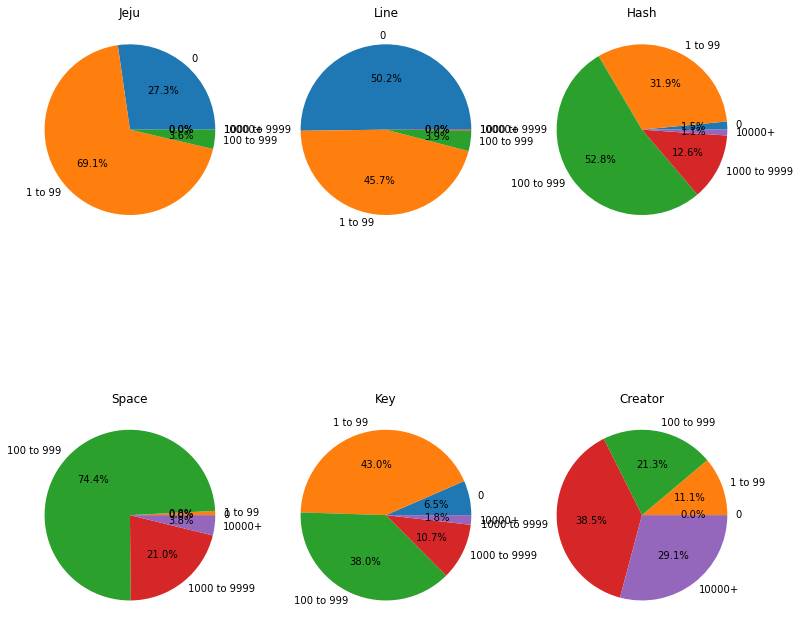

In [683]:
i = 0
plt.figure(figsize=(13,13))
print('Distribution of Followers')
for df in dfs:
    #How many friends do they have?
    plt.subplot(231+i)
    friend_range=pd.cut(df['Followers'],bins=[-1,0,100,1000,10000,100000],labels=['0','1 to 100','101 to 1000','1001 to 10000','10000+'])
    dataforpie=friend_range.value_counts().sort_index()
    plt.pie(dataforpie,labels=['0','1 to 99','100 to 999','1000 to 9999','10000+' ],autopct='%1.1f%%',)
    plt.title(types[i])
    i=i+1
plt.show()

A big majority of Spam dfs has 0 or 1 to 99 followers. Jeju prefers to use accounts has at least a few followers and Line prefers to use ones with 0 followers (although the next majority is accounts with a few followers). I also think people with median followers(100 to 999) are most actively using Space modules. 

Distribution of Friends


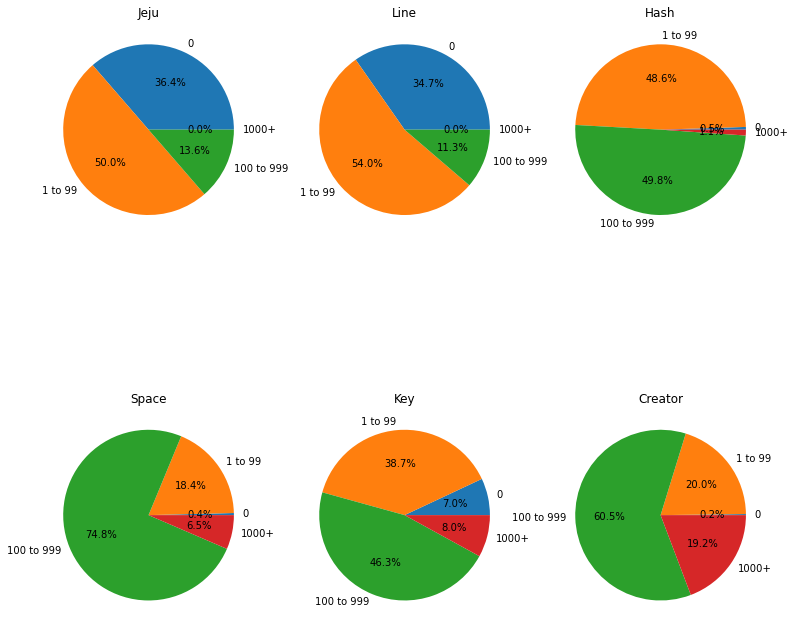

In [687]:
i = 0
plt.figure(figsize=(13,13))
print('Distribution of Friends')
for df in dfs:
    #How many friends do they have?
    plt.subplot(231+i)
    friend_range=pd.cut(df['Friends'],bins=[-1,0,100,1000,10000],labels=['0','1 to 100','101 to 1000','1000+'])
    dataforpie=friend_range.value_counts().sort_index()
    plt.pie(dataforpie,labels=['0','1 to 99','100 to 999','1000+'],autopct='%1.1f%%',)
    plt.title(types[i])
    i=i+1
plt.show()

Seems like spam accounts are following each other(become friends) rather to be seem like an empty account with 0 friends. All the other dfs have a reasonable amount of friends (0 to 999, which I think is managable). I can say that non spam dfs are verified to have reasonable amount of friends to be active in Twitter compared to spam dfs

Distribution of Account Age(Y)


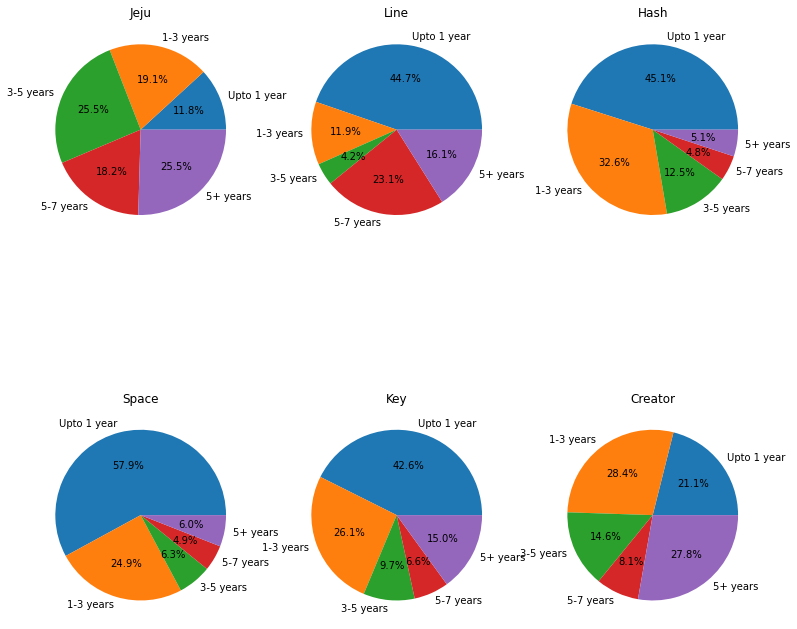

In [679]:
i = 0 
plt.figure(figsize=(13,13))
print('Distribution of Account Age(Y)')
for df in dfs:
    #How old are they?
    plt.subplot(231+i)
    created_range=pd.cut(df.Create2Tweet,bins=[timedelta(days=0),timedelta(days=365),timedelta(days=365*3),timedelta(days=365*5),timedelta(days=365*7),timedelta(days=4772)])
    dataforpie=created_range.value_counts().sort_index()
    plt.pie(dataforpie,labels=['Upto 1 year','1-3 years','3-5 years','5-7 years','5+ years'],autopct='%1.1f%%',)
    plt.title(types[i])
    i=i+1
plt.show()

Jeju seems like randomizing within 5.5% error in choosing which account to hack or use to spam tweet compared to Line. Line seems to be mimicking the actual distribution of accounts with a bit of preference to old accounts. Regarding that Hash, Space, and Key are mostly made of average users, Line seems indistinguishable among those in a context of account ages. Also, Note that most users of Creator df are accounts older than a year, which could indicate df is made of people who made consistent effort on tweets, which is a common characteristic of official creators

Distribution of Number of Hashtags


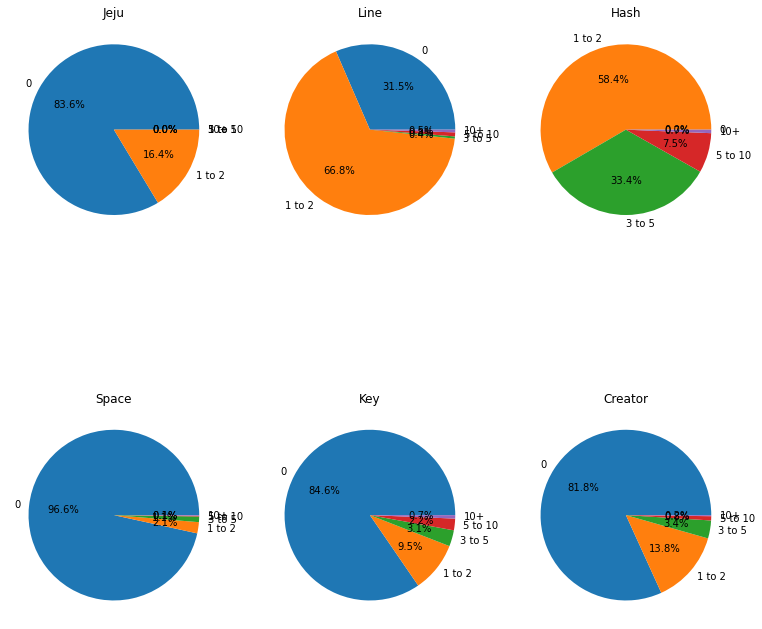

In [680]:
i = 0
plt.figure(figsize=(13,13))
print('Distribution of Number of Hashtags')
for df in dfs:
    #How long is their Display name?
    plt.subplot(231+i)
    hashlen_range=pd.cut(df.Hashlen,bins=[-1,0,2,5,10,20])
    dataforpie=hashlen_range.value_counts().sort_index()
    plt.pie(dataforpie,labels=['0','1 to 2','3 to 5','5 to 10','10+'],autopct='%1.1f%%',)
    plt.title(types[i])
    i=i+1
plt.show()

Seems like people just don't usually use hashtags. All items in Hash df should have some hashtags because it's a hashtag search result. Line is mostly encompassing one or two hashtags. I don't think it is the best way to use # of hashtags to sort out spam or non spams.

Distribution of Length of Userid


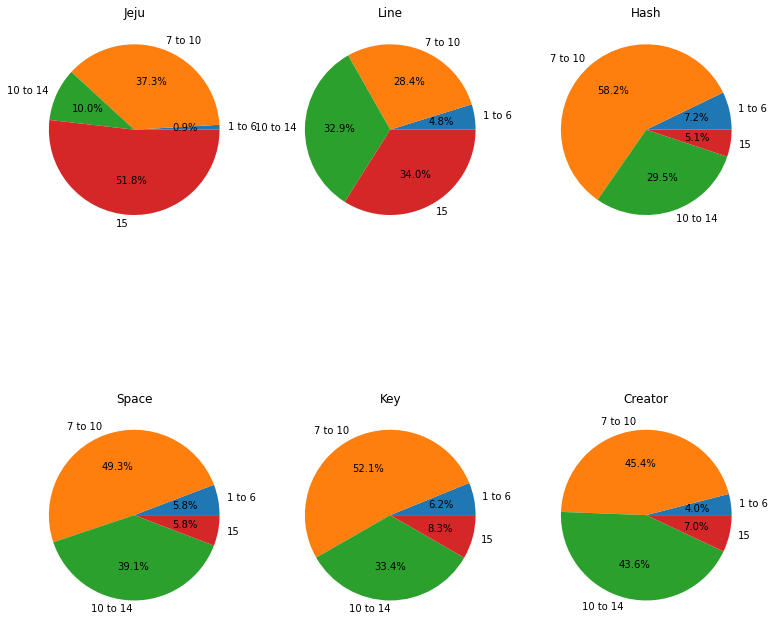

In [681]:
i = 0
plt.figure(figsize=(13,13))
print('Distribution of Length of Userid')
for df in dfs:
    #How long is their user id (@userid)
    plt.subplot(231+i)
    userlen=df['Username'].str.len()
    userlen_range=pd.cut(userlen,bins=[1,6,10,14,15])
    #15 is the default userid length in twitter when new account is made
    dataforpie=userlen_range.value_counts().sort_index()
    plt.pie(dataforpie,labels=['1 to 6','7 to 10','10 to 14','15'],autopct='%1.1f%%',)
    plt.title(types[i])
    i=i+1
plt.show()

I speicified the 15 character UserID beacause that's the default length of the id given by Twitter system when people first make an account. Real users like to change their ID to their taste, usually shorter in a length. As expected, spam dfs were mostly made of 15 character UserID, which could be because the accounts were abandoned after a short period of time with no effort to change their UserID. I already treated on length of DisplayID in the beginning for Line. Seems like most people like to use 7 to 10 character ID overall.

Distribution of Statuses


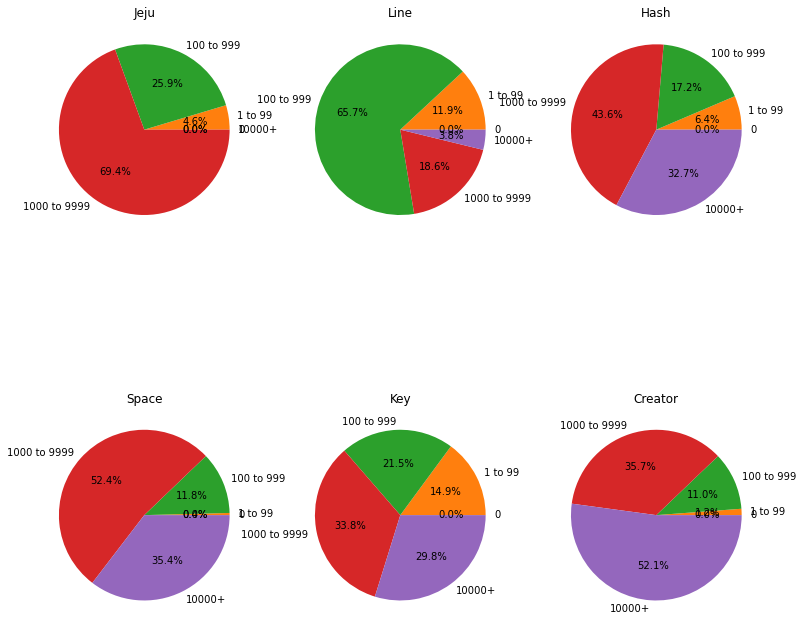

In [682]:
i = 0
plt.figure(figsize=(13,13))
print('Distribution of Statuses')
for df in dfs:
    #How many statuses have they posted?
    plt.subplot(231+i)
    follow_range = pd.cut(df['Statuses'],bins=[-1,0,100,1000,10000,100000],labels=['0','1 to 100','101 to 1000','1001 to 10000','10000+'])
    dataforpie=follow_range.value_counts().sort_index()
    plt.pie(dataforpie,labels=['0','1 to 99','100 to 999','1000 to 9999','10000+'],autopct='%1.1f%%',)
    plt.title(types[i])
    i=i+1
    
plt.show()

Jeju is spamming with no limits but not as much as 10000+. It could be because they simply can't do it because of limitation of their API or gets caught if they spam too much. Line don't even go as far as 1000. They could use more accounts to spam or don't even need to spam as much as Jeju. 
The reason why I looked up for the # of statuses is because my friends usually like to regularly autodelete their tweets, so I was expecting non spam dfs to have less tweets than spam dfs. but it was not true for everyone. Some people like to just keep it going, some people don't. It could be better if I can check how many tweets were deleted by each user, but it was beyond my API's scope.

# Tweet Analysis

## Content Analysis
Content made of automatic keywords should have very less verbs, since it's not a sentence

In [218]:
from konlpy.tag import Okt
konlpy.jvm.init_jvm(max_heap_size=1024)
okt=Okt() #had to change Java_Home path manually on MacOS to call this
#Okt is previously called Twitter and it seems like it's the most suitable package for SNS speech

In [375]:
Determiners=('Noun','Verb','Adverb','Conjunction','Exclamation','Josa','PreEomi','Eomi','Suffix','Punctuation','Foreign','Alpha',
            'Number','Unknown','KoreanParticle','Hashtag','ScreenName')
for df in dfs:
    kodf=df.Content.map(lambda x: np.array(okt.pos(x))[:,1])
    kodf=kodf.map(lambda x: dict(zip(list(np.unique(x,return_counts=True)[0]), list(np.unique(x,return_counts=True)[1]))))
    df['MadeOf']=kodf


In [690]:
#table summary
i=0
for df in dfs:
    print(types[i])
    i = i+1
    print()
    dfa=pd.DataFrame()
    dfcont=pd.DataFrame(df.Content)
    for det in Determiners:
        dfcont[det]=pos_per(df,det)
    dfforkey=dfcont.min(numeric_only=True)
    dfa['Keys']=dfforkey.keys()
    dfa['Min']=pd.Series(list(dfcont.min(numeric_only=True)))
    dfa['Avg']=pd.Series(list(dfcont.mean(numeric_only=True)))
    dfa['Median']=pd.Series(list(dfcont.median(numeric_only=True)))
    dfa['Max']=pd.Series(list(dfcont.max(numeric_only=True)))

    print(dfa.head(2))
    print('Noun to Verb Ratio:',dfa.Avg[0]/dfa.Avg[1])
    print()
    print()
    print('--------------------------------------')
    print()
    print()

Jeju

   Keys       Min       Avg    Median       Max
0  Noun  0.333333  0.588532  0.573593  0.941176
1  Verb  0.000000  0.026286  0.000000  0.166667
Noun to Verb Ratio: 22.389921723445426


--------------------------------------


Line

   Keys  Min       Avg  Median       Max
0  Noun  0.0  0.499588     0.5  0.882353
1  Verb  0.0  0.014633     0.0  0.363636
Noun to Verb Ratio: 34.140847612470175


--------------------------------------


Hash

   Keys  Min       Avg    Median       Max
0  Noun  0.0  0.340496  0.363636  0.666667
1  Verb  0.0  0.073658  0.071429  0.375000
Noun to Verb Ratio: 4.62264470425018


--------------------------------------


Space

   Keys  Min       Avg    Median  Max
0  Noun  0.0  0.325412  0.343304  1.0
1  Verb  0.0  0.104976  0.083333  1.0
Noun to Verb Ratio: 3.099869321246536


--------------------------------------


Key

   Keys  Min       Avg    Median       Max
0  Noun  0.0  0.428955  0.444444  1.000000
1  Verb  0.0  0.091618  0.083333  0.666667
Noun t

I found that tweets that use keyword spamming has very high noun to verb ratio(20 to 40) where as clean tweets have about(3 to 4) ratio. Therefore, I assume many spam tweets are not made of actual sentences

# Joint Analysis and Modeling

## NV ratio
NVratio = Noun to Verb ratio

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

Jeju 0 verbs:61 out of 110 items 0.55
Line 0 verbs:648 out of 700 items 0.93
Hash 0 verbs:159 out of 700 items 0.23
Space 0 verbs:279 out of 700 items 0.40
Key 0 verbs:302 out of 700 items 0.43
Creator 0 verbs:53 out of 500 items 0.11


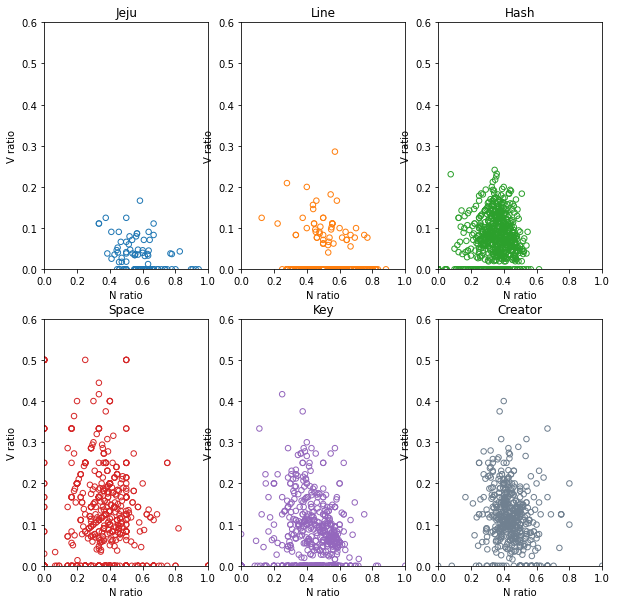

In [800]:
colors=('tab:blue','tab:orange','tab:green','tab:red','tab:purple','slategrey')

i=0
plt.figure(figsize=(10,10))

for df in dfs:
    plt.subplot(231+i)
    plt.title(types[i])
    plt.xlim([0,1])
    plt.xlabel('N ratio')
    plt.ylim([0,.6])
    plt.ylabel('V ratio')
    #dflim=df.drop_duplicates(subset=['Username'])
    dflim=df
    dflim=dflim.head(700)
    x=pos_per(dflim,'Noun')
    y=pos_per(dflim,'Verb')
    plt.scatter(x, y,edgecolors=colors[i],facecolors='none',s=30)
    print(types[i],'0 verbs:{0} out of {1} items {2}'.format(y.value_counts()[0],len(y),"{:.2f}".format(y.value_counts()[0]/len(y))))
    i=i+1


- Jeju df is getting clustered on right bottom, and honestly it has too less data compared to other datasets
- Line df is mostly in the bottom, proving that most of their tweets are purely made of nouns. The number of items are the same as the other four non-spam dfs, so non-clusttering behavior cannot be explained by shortage in datapoints
- all the other non-spam dfs are getting clusttered on bottom and left-ish center
- I assume Space is less clustered than other dfs because more of data was collected from the middle of a conversation with other users, and so written with less efforts. To prove this hypothesis, I will take out tweets collected from convos, which can be verified if the tweet starts with @userid and calculate C-H index, paramter for clusteredness. Higher CH, more clustered it is.

/var/folders/p8/ggm3r0bx14sbjsb1ksyg2y6c0000gn/T/ipykernel_25098/82204096.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  noconvo=spacedf[~spacedf.Content.str.contains(r"^@(\w+)")]


No Convo Space 0 verbs:129 out of 396 items 0.33
        C-H index: 316.94259531948154
Mixed Space 0 verbs:163 out of 396 items 0.41
        C-H index: 357.42905927275757


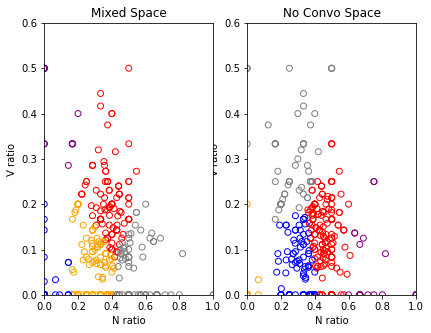

In [869]:
noconvo=spacedf[~spacedf.Content.str.contains(r"^@(\w+)")]

plt.figure(figsize=(3.33333*2,5))
plt.subplot(122)
plt.title('No Convo Space')
plt.xlim([0,1])
plt.xlabel('N ratio')
plt.ylim([0,.6])
plt.ylabel('V ratio')
dflim=noconvo
dflim=dflim.head(396)
x=pos_per(dflim,'Noun')
y=pos_per(dflim,'Verb')
X=np.column_stack((x,y))
kmeans = KMeans(n_clusters=5, random_state=1)
labels = kmeans.fit_predict(X)
ch_index = calinski_harabasz_score(X, labels)
unique_labels = list(set(labels))

colors = ['red', 'orange', 'grey','blue','purple','magenta','green','cyan']
j=0
for j in unique_labels:
    filtered_label = X[labels == j]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], facecolors='none', edgecolor=colors[j])

print('No Convo Space','0 verbs:{0} out of {1} items {2}'.format(y.value_counts()[0],len(y),"{:.2f}".format(y.value_counts()[0]/len(y))))
print('        C-H index:',ch_index)



plt.subplot(121)
plt.title('Mixed Space')
plt.xlim([0,1])
plt.xlabel('N ratio')
plt.ylim([0,.6])
plt.ylabel('V ratio')
dflim=spacedf
dflim=dflim.head(396)
x=pos_per(dflim,'Noun')
y=pos_per(dflim,'Verb')
X=np.column_stack((x,y))
kmeans = KMeans(n_clusters=5, random_state=1)
labels = kmeans.fit_predict(X)
ch_index = calinski_harabasz_score(X, labels)
unique_labels = list(set(labels))

colors = ['red', 'orange', 'grey','blue','purple','magenta','green','cyan']
j=0
for j in unique_labels:
    filtered_label = X[labels == j]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], facecolors='none', edgecolor=colors[j])
    
print('Mixed Space','0 verbs:{0} out of {1} items {2}'.format(y.value_counts()[0],len(y),"{:.2f}".format(y.value_counts()[0]/len(y))))
print('        C-H index:',ch_index)




CH index didn't change much by filtering, but visually, we can see that the two dominant clusters in the mixed df has less N ratio(0.2-0.4) and spreaded V ratios(0.0-0.3), whereas the new two dominant clusters in no convo has more spreaded N ratio (0.2-0.6) and has low V ratios(0.2-0.0). This represents that the dominant Content type shifted to have various ratio of Nouns and lesser Verbs than before filtering. This made me wonder the cluster spread of other dfs.

hash  Cluster Score:  518.1910991416082 out of  500 items


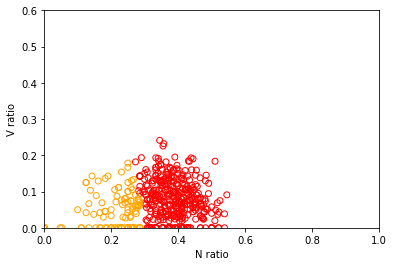

space  Cluster Score:  437.2316633756425 out of  500 items


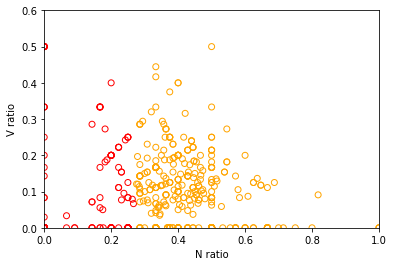

key  Cluster Score:  1687.2206956162404 out of  500 items


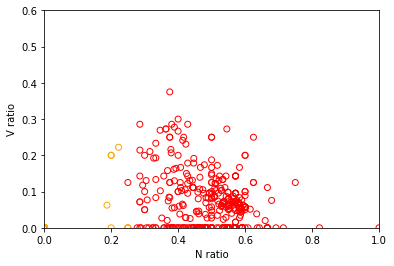

creator  Cluster Score:  331.1663158946268 out of  500 items


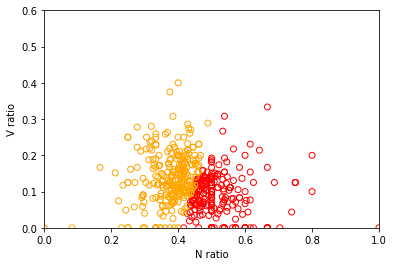

In [882]:
i=0

#Excluded spam dfs to see the distribution of real tweets
nospamdfs=(hashdf,spacedf,keydf,creatordf)
nospamtypes=('hash','space','key','creator')
for df in nospamdfs:
    dflim=df.head(500)
    
    x=pos_per(dflim,'Noun')
    y=pos_per(dflim,'Verb')
    X=np.column_stack((x,y))
    kmeans = KMeans(n_clusters=2, random_state=30)
    labels = kmeans.fit_predict(X)
    ch_index = calinski_harabasz_score(X, labels)
    unique_labels = list(set(labels))
    print(nospamtypes[i],' Cluster Score: ',ch_index, 'out of ',len(dflim),'items')
    
    colors = ['red', 'orange', 'grey','blue','purple','magenta','green','cyan']
    plt.xlim([0,1])
    plt.xlabel('N ratio')
    plt.ylim([0,.6])
    plt.ylabel('V ratio')
    j=0
    for j in unique_labels:
        filtered_label = X[labels == j]
        plt.scatter(filtered_label[:,0], filtered_label[:,1], facecolors='none', edgecolor=colors[j])

    plt.show()
    i=i+1

- hash  Cluster Score:  518.1910991416082 out of  500 items
- space  Cluster Score:  437.2316633756425 out of  500 items
- key  Cluster Score:  1687.2206956162404 out of  500 items
- creator  Cluster Score:  331.1663158946268 out of  500 items



- Hash: I expected Hash to be highly clustered because it is a collection of people sharing a same interest talkina about same topic. And people tend to learn how to speak(type) from their friends. Expectedly, it has the second highest CH value among nospam dfs. Regarding that Key cluster has abnormaly high CH values, my hypothesis is satisfied.

- space: I expected it to be very less clustered since it's the most random collection. No shared interst, no shared topic. It has fairly low CH value but not the lowest

- key: It has abnormally big CH value. At first I thought this could be because there are some same topics they all share, but regarding that there are total of 20 trending topic(keywords) to share, it's a bit odd. I looked up what kind of keywords I collected last time, and found #에스엠_레드벨벳_콘서트_돌려놔 among the trending keywords. That was why it was so clustered. These kind of hashtags are called 총공, which a bunch of people post the same hashtag to make it trending and make their issue to be exposed to bigger public. Also, Many of them are non-Korean tweets, which KoNLPy just clusters them as "Foreign".

- creator: It has the least CH value, which makes sense since the df is mainly made of creators, who are the few selected people from the various groups of people talking about various topics.

In [900]:
#Do Keys actually have high Foreign in their tweets?
len(keydf.head(500)[keydf.Content.head(500).str.contains('#에스엠_레드벨벳_콘서트_돌려놔')])
# Yes, out of 500 head tweets, 100 of them are using #에스엠_레드벨벳_콘서트_돌려놔 hashtag
pos_per(keydf.head(500)[keydf.Content.head(500).str.contains('#에스엠_레드벨벳_콘서트_돌려놔')],'Foreign').mean()
# Yes, they are dominantly made of Alphabets 
# Hypothesis verified

0.15286311540232714